# DataPrep e Classificador entre Navios e Baleias por Keras MLP
## Grupo 2 - Trabalho de Conclusão de Curso
### - Bruno Uchôa Brandão e Silva - 12412440
### - Rayan Luz Ralile - 12412502

===============================================================================

### Passo 1: carregamento das bibliotecas usadas no programa

In [1]:
import numpy as np
import scipy.signal
import librosa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.models import load_model
from keras.callbacks import Callback
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import calendar
import time

2023-11-14 13:44:52.178345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Passo 2: construção das funções auxiliares

In [2]:
# Funções de salvar e carregar objetos diversos - otimizar os passos de tratamento do dataset e treino
def salva_objeto(obj, file_path = "data.pickle"):
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)
        
def carrega_objeto(file_path = "data.pickle"):
    with open(file_path, 'rb') as file:
        obj = pickle.load(file)
    return obj

### Passo 3: realizar o DataPrep dos áudios, considerando a mesma estratégia de STFT anterior, com bins de frequências. Além disso, áudios de 1 até 10.wav são de navios (etiqueta 0) e de 11.wav até o 20.wav são de baleias (etiqueta 1 - áudios do PMPAS-BS).

## Importante: devido ao termo assinado para uso dos dados do PMPAS-BS, os arquivos não se encontram no GitHub. Portanto, o código abaixo não vai funcionar.

In [3]:
if False: # o código abaixo não funciona sem os dados brutos .WAV do PMPAS-BS
    
    # Lê os arquivos de áudio e processa a técnica PSD
    def compute_psd(file_path, center_time):
        audio_data, original_sample_rate = librosa.load(file_path, sr=None)
        # original_sample_rate -> 48000Hz
        # Decima os dados de áudio
        audio_data = librosa.resample(audio_data, orig_sr=original_sample_rate, target_sr=4800)
        sample_rate = 4800


        # Computar o início e fim em torno do tempo de PMA em máx de 10 minutos
        start_sample = max(0, int((center_time - 2.5 * 60) * sample_rate))
        end_sample = min(len(audio_data), int((center_time + 2.5 * 60) * sample_rate))

        # Verifica se o tempo está completo
        if end_sample - start_sample != 5 * 60 * sample_rate:
            raise ValueError("Verificar argumento center_time - não efetivou intervalo por inteiro")


        audio_data = audio_data[start_sample:end_sample]
        # Reshape a matriz para as 300 amostras de 1 segundo cada
        chunks = audio_data.reshape(300, sample_rate)

        # Computar a densidade espectral de frequência usando o método Welch do SciPy
        psd_list = []
        for chunk in chunks:
            freqs, psd = scipy.signal.welch(chunk, sample_rate, nperseg=480, noverlap=240)
            # Seleciona as baixas frequências, de 10Hz a 2000Hz
            psd = psd[(freqs >= 10) & (freqs <= 2000)]
            psd_list.append(psd)
        return np.array(psd_list)

    classifications = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    # 0 - navios
    # 1 - baleias

    arquivos_wav = []

    folderPMPAS_ETAS = '../PMPAS_ETAS_WAV/'

    for i in range(1, 20):
        nome_arquivo = folderPMPAS_ETAS + str(i) + ".wav"
        arquivos_wav.append(nome_arquivo)

    # agora a lista dos tempos de centro em segundos para os navios e fixo para as baleias
    arrayTempos = [1840, 1680, 1710, 1700, 1700, 1840, 1840, 1800, 1800, 1800, 150, 150, 150, 150, 150,
                  150, 150, 150, 150, 150]


    dataset = []
    labels = []
    contador = 0
    # Loop através dos arquivos de áudio
    for audio_file_path, audio_class in zip(arquivos_wav, classifications):
        psd = compute_psd(audio_file_path, arrayTempos[contador])
        dataset.extend(psd)
        labels.extend([audio_class]*300)  # Repete a classificação para as 300 amostras - etiquetagem
        contador += 1

    # Converte para numpy
    dataset = np.array(dataset)
    labels = np.array(labels)

    # Normaliza dataset com o método Min-Max
    scaler = MinMaxScaler()
    dataset = scaler.fit_transform(dataset)

    # Salva o dataset e as labels
    salva_objeto(dataset,"dataset_baleias_navios.pickle")
    salva_objeto(labels,"labels_baleias_navios.pickle")

### Entretanto, o arquivo oriundo desse tratamento dos dados dentro dos áudios não está restrito, portanto, o código abaixo vai funcionar e permitir treinar a rede separadora de sinais navios-baleias:

In [4]:
dataset = carrega_objeto("dataset_baleias_navios.pickle")
labels = carrega_objeto("labels_baleias_navios.pickle")

### Passo 4: fazer a divisão do dataset em treino e teste:

In [5]:
data = dataset


X = data
y = labels

# Divisão entre teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Passo 5: treinar e verificar desempenho básico incluindo matriz confusão do seletor 'navios-baleias':

In [6]:
# Prepara label para ser entendido na rede neural sem prejudicar os pesos
labels = labels.astype(int)
labels = np.eye(2)[labels] 

# divide os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
# cria o modelo com 800 neurônios na camada oculta, conectados a 200 na entrada e 2 na saída
model = Sequential([
    Dense(800, activation='relu', input_shape=(200,)),
    Dense(2, activation='softmax')
])

# Configura o learning_rate do otimizador ADAM
optimizer = Adam(learning_rate=0.01)
#optimizer = Adam(learning_rate=0.00000001) # 1E-8

# compila configurações (bala na agulha)
# Compila o modelo, definindo o otimizador, a função de perda e a métrica de desempenho
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=0)


2023-11-14 13:45:16.137116: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Passo 6: salvar a rede treinada

In [7]:
model.save('modelBaleiasNavios2.h5')

### Passo 7: matriz confusão do seletor navios e baleias

36/36 [==============================] - 0s 4ms/step


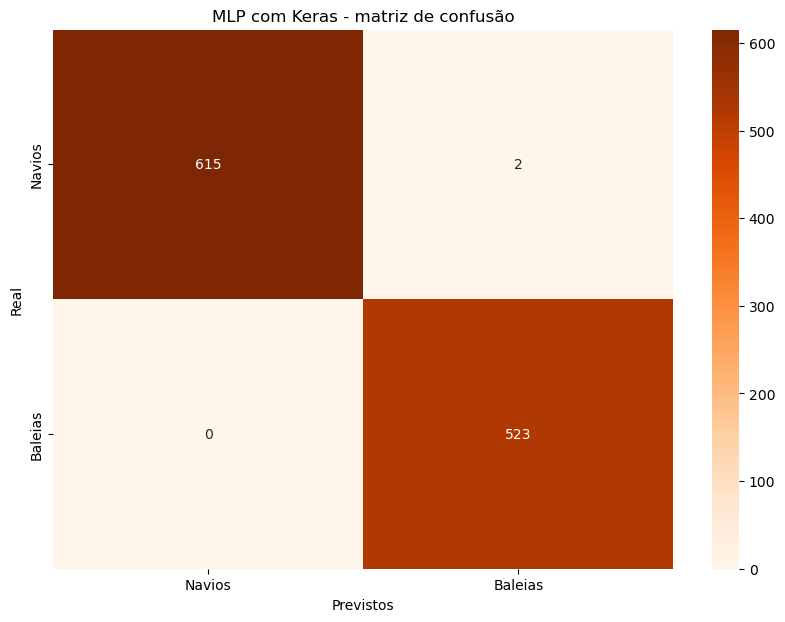

In [8]:
# Define os nomes de classes para substituir pelos números - caminho reverso
class_names = ['Navios', 'Baleias']

# Uso do modelo para preditar sobre a base de testes
predictions = model.predict(X_test)

# Pega os pontos maiores de cada classificação para definir a classe
predicted_labels = np.argmax(predictions, axis=1)

# Idem para os labels verdadeiros - reais
true_labels = np.argmax(y_test, axis=1)

# Realiza a matriz de confusão
cm = confusion_matrix(true_labels, predicted_labels)

# Cria o mapa de calor da matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previstos')
plt.ylabel('Real')
plt.title('MLP com Keras - matriz de confusão')
plt.show()